In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
customers = "/content/drive/MyDrive/BT4222/data/pickles/df_c_train_cs.pkl"
transactions = "/content/drive/MyDrive/BT4222/data/pickles/df_t_train_fe.pkl"
items = "/content/drive/MyDrive/BT4222/data/pickles/df_i_fe.pkl"

df_c = pd.read_pickle(customers)
df_t = pd.read_pickle(transactions)
df_i = pd.read_pickle(items)

In [ ]:
df_t.sample(3)

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
8759457,2019-04-14,9393f2d138581d3ed0d6a98eed9386bf562b5fc80e5ac5...,711521004,0.025407,2,0 days
9278036,2019-04-24,e655480b0d1f679e6ddd09e0b6a40704331dd494db0ca7...,685811003,0.015576,1,NaT
8740602,2019-04-14,2209fc705ea2a56ec5863d6311a724a17aab1d5b3f7228...,609170003,0.030492,2,0 days


In [ ]:
df_c.sample(5)

,customer_id,Customer_Characteristics_Cluster,Transactional_Behaviour_Cluster
421006,e85a7f98cf70f57393927b2e38c19a9e55d19124c97080...,0,1
149402,529c18a21b1f165506f27e1190d839a9642effef7ddc02...,0,2
119408,42131310c38f87eb0148bedce797a20995e09b8a856daa...,0,4
362733,c7ff9ef489a00d8d29a8d711b71f0206d53e73d1cc7f57...,0,0
199240,6de31b81f415355616f08395878a41f6af58256c1cd576...,0,0


In [ ]:
df_c['Customer_Characteristics_Cluster'].value_counts()

Customer_Characteristics_Cluster
0    282689
1    181050
Name: count, dtype: int64

In [ ]:
df_t.sample(5)

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
10342110,2019-05-16,9be6c94d346fbc98119f64647cdd3ed1ce91e9d55567a5...,759871002,0.005068,2,0 days
10274621,2019-05-15,ce24db950d374d255432b6b43af1d8575099da6afc21b6...,756209001,0.040729,2,36 days
9356954,2019-04-26,237d71e5aecb84cc788c3db18d1ccbd54e3a12be8d5b82...,717727003,0.032864,2,0 days
9099980,2019-04-22,0b139ffee2066ad25108015dce61808e5decd82d1744f7...,748030002,0.022017,2,0 days
9978680,2019-05-08,4e50cb7b8b533a179cfb18979f65646b4f3130fe8fdc0c...,685448004,0.025407,2,0 days


In [ ]:
df_i.sample(5)

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding,popularity,price_range
85975,821886004,Electric Suede Biker,262,Jacket,Garment Upper body,Solid,Light Beige,Dusty Light,Beige,Divided,Outdoor,Biker jacket in soft imitation suede with a co...,"Electric Suede Biker, Jacket, Garment Upper bo...","[-0.7221681, 1.6488051, 1.3297321, 0.5585364, ...",NaN,NaN
6520,506410007,SB Tyler Sport Set,270,Garment Set,Garment Full body,Placement print,Dark Grey,Medium Dusty,Grey,Sport,Unknown,Sports set with a sports top and pair of sport...,"SB Tyler Sport Set, Garment Set, Garment Full ...","[-0.83814716, 1.7781723, 1.2662709, -0.0049488...",1.0,Medium
48302,691566001,Swift lace and chiffon dress,265,Dress,Garment Full body,Lace,Black,Dark,Black,Ladieswear,Dresses Ladies,Long-sleeved dress with a lace bodice and V-ne...,"Swift lace and chiffon dress, Dress, Garment F...","[-0.028557582, 1.9241028, 1.441744, 0.69546044...",3.0,High
53596,705143003,Class Olle dog sweter,78,Other accessories,Accessories,Solid,Dark Blue,Dark,Blue,Ladieswear,Accessories,Cable-knit dog jumper containing some wool wit...,"Class Olle dog sweter, Other accessories, Acce...","[-0.121352516, 1.1461918, 1.1074046, -0.424606...",1.0,Medium
5065,489607003,Hailey cross bag (1),66,Bag,Accessories,Solid,Greenish Khaki,Dark,Mole,Ladieswear,Accessories,Small bag in regenerated leather with a narrow...,"Hailey cross bag (1), Bag, Accessories, Dark, ...","[-0.80699134, 1.305759, 1.1535305, -0.06709617...",3.0,Medium


# Time-infused Collaborative Filtering

In [ ]:
# Concatenate the three cluster columns into a single key column
df_c['cluster_key'] = df_c['Customer_Characteristics_Cluster'].astype(str) + '_' + \
                    df_c['Transactional_Behaviour_Cluster'].astype(str)

# Group customers based on the cluster key
grouped_customers = df_c.groupby('cluster_key')

In [ ]:
df_c['cluster_key'].unique() # all the clusters of customers

array(['1_0', '0_3', '1_4', '0_4', '1_3', '0_1', '1_1', '0_0', '0_2',
       '1_2'], dtype=object)

In [ ]:
week_of_purchase = df_t['t_dat'].dt.isocalendar().week.astype('int')
min_week = week_of_purchase.min()

week_of_purchase_zeroed = week_of_purchase - min_week
df_t['week_of_purchase'] = week_of_purchase_zeroed

In [ ]:
def compute_user_similarity(transactions, customers, cluster_key):
    # Filter customers based on the cluster_key
    filtered_customers = customers[customers['cluster_key'] == cluster_key]

    # Filter transactions based on the customer IDs from filtered_customers
    filtered_transactions = transactions[transactions['customer_id'].isin(filtered_customers['customer_id'])]
    filtered_transactions = filtered_transactions[['customer_id', 'article_id', 'week_of_purchase']]

    # Convert customer IDs and article IDs to indices
    customer_encoder = LabelEncoder()
    article_encoder = LabelEncoder()

    filtered_transactions['customer_idx'] = customer_encoder.fit_transform(filtered_transactions['customer_id'])
    filtered_transactions['article_idx'] = article_encoder.fit_transform(filtered_transactions['article_id'])

    # Create the sparse matrix
    # using week_of_purchase as the element in the matrix
    user_item_matrix = csr_matrix((filtered_transactions['week_of_purchase'],
                                   (filtered_transactions['customer_idx'], filtered_transactions['article_idx'])))

    user_similarity = cosine_similarity(user_item_matrix, dense_output=False)

    return user_similarity, customer_encoder, article_encoder

def top_k_neighbors(user_similarity_matrix, k=50):
    # Initialize a list to store the top k neighbors for each user
    top_neighbors = []

    # Iterate over each row in the user similarity matrix
    for i in range(user_similarity_matrix.shape[0]):
        # Get the similarity scores for the current user
        similarity_scores = user_similarity_matrix[i, :].toarray().ravel()

        # Find the indices of the top k similarity scores
        top_k_indices = np.argpartition(similarity_scores, -k)[-k:]

        top_k_indices_sorted = sorted(top_k_indices, key=lambda x: similarity_scores[x], reverse=True)

        # Create a list of tuples containing (user_index, similarity_score) pairs
        top_k_neighbors_for_user = [(idx, similarity_scores[idx]) for idx in top_k_indices_sorted]

        # Append the top k neighbors for the current user to the list
        top_neighbors.append(top_k_neighbors_for_user)

    return top_neighbors

In [ ]:
cluster_to_closest_neighbours_mapping = {}
cluster_to_customer_encoder_mapping = {}
cluster_to_article_encoder_mapping = {}

for cluster_key in df_c['cluster_key'].unique():
    user_similarity, customer_encoder, article_encoder = compute_user_similarity(df_t, df_c, cluster_key)

    # Within the user_similarity matrix, retrieve the top 60 closest neighbours
    cluster_to_closest_neighbours_mapping[cluster_key] = top_k_neighbors(user_similarity, k=60)
    cluster_to_customer_encoder_mapping[cluster_key] = customer_encoder
    cluster_to_article_encoder_mapping[cluster_key] = article_encoder

In [ ]:
def get_top_k_recommendations_for_user(user_id, closest_neighbours_matrix, transactions, customer_encoder, k):
    user_index = customer_encoder.transform([user_id])[0]
    neighbours_indices = closest_neighbours_matrix[user_index]
    neighbour_users_ids = [customer_encoder.inverse_transform([neighbour[0]])[0] for neighbour in neighbours_indices if neighbour[0] != user_index]

    # Create a mapping dictionary for neighbour_user_ids and their indices
    neighbour_user_id_index_map = {user_id: index for index, user_id in enumerate(neighbour_users_ids)}

    # Filter transactions based on neighbour user IDs
    filtered_transactions = transactions[transactions['customer_id'].isin(neighbour_users_ids)].copy()

    # Map customer_id to its corresponding index in neighbour_user_ids
    filtered_transactions['neighbour_user_id'] = filtered_transactions['customer_id'].map(neighbour_user_id_index_map)

    # Sort filtered transactions by neighbour_user_ids in descending order
    filtered_transactions.sort_values(by='neighbour_user_id', inplace=True)

    # Get items interacted by the current user
    user_to_recommend = customer_encoder.inverse_transform([user_index])[0]
    user_interacted_items = transactions[transactions['customer_id'] == user_to_recommend]['article_id'].unique()

    # Remove items interacted by the current user from recommendations
    items_to_recommend = filtered_transactions[~filtered_transactions['article_id'].isin(user_interacted_items)]['article_id'].drop_duplicates().iloc[:k]

    return items_to_recommend

# Content-Based Recommender

In [ ]:
class ContentRecommenderSys:
    def __init__(self, transactions, items):
        # CONSTANTS
        self.TIME_MAX = transactions['t_dat'].max()

        self.transactions = transactions
        self.items = items
        self.interacted = transactions.groupby('customer_id')['article_id'].apply(list).to_dict() # maps a user to a list of their purchased items
        self.time_interacted = transactions.groupby('customer_id')['t_dat'].apply(list).to_dict() # maps a user to a list of timestamps of their purchases

        self.embeddings = np.array([np.array(x) for x in items['embedding']])

        self.final_scores = {} # maps each user to an item vector with elements containing recommendations scores for each item
        self.final_recommendations = {} # maps each user to top K recommended items

    def calculate_exponential_weight(self, time_interacted, decay_constant):
        return np.exp(-1 * decay_constant * (self.TIME_MAX - time_interacted).days)


    def get_current_interactions(self, userid):
        """
        Returns all the description of all items the user had transacted.
        """
        item_desc = []
        interacted_items = self.interacted[userid]

        for item in interacted_items:
            idx = df_i[df_i['article_id'] == item].index[0]
            item_desc.append(idx)

        return df_i.iloc[item_desc, :]

    def get_recommendations(self, k, userid, decay_constant = 0.3):
        interacted_items = self.interacted[userid]
        interacted_timestamp = self.time_interacted[userid]

        weights = []
        scores = []

        # For each interacted item by the user
        for i in range(0, len(interacted_items)):
            # Compute the weight to be applied (adjusted for decay)
            weights.append(self.calculate_exponential_weight(interacted_timestamp[i], decay_constant)) #default decay constant value = 0.3

            # Perform search for similar products
            idx = df_i[df_i['article_id'] == interacted_items[i]].index[0]
            embedding_list = df_i['embedding']
            query_embedding = embedding_list.iloc[idx,].reshape(1, -1) # get query embedding
            sim_vector = cosine_similarity(query_embedding, self.embeddings).flatten()

            # Assign the equivalent items' scores to be 0 (prevent interacted items from being recommended again)
            sim_vector[sim_vector >= 1.0] = 0
            scores.append(sim_vector)

        # apply weight to each corresponding score
        final_ranking = np.dot(weights, scores) / len(interacted_items)

        # save item-vector score for reference
        self.final_scores[userid] = final_ranking

        # Get Top K results (K Highest scores), results are the index of the items in the matrix
        recommend_list = final_ranking.argsort()[::-1][:k]

        # Get article Ids from indexes
        articles_recommend = self.items.iloc[recommend_list, :]['article_id']

        # Store in dictionary for future reference
        self.final_recommendations[userid] = articles_recommend

        return articles_recommend


Let us see how the decay constant change its weight as days passes by.

In [ ]:
def calculate_decay_constant(day, decay_constant):
    return np.exp(-1 * decay_constant * day)

def plot_decay_constant_over_time(decay_constant, max_days):
    days = np.arange(0, max_days + 1)
    decay_constants = [calculate_decay_constant(day, decay_constant) for day in days]

    plt.plot(days, decay_constants)
    plt.title(f'Decay Constant {(decay_constant)} over Time')
    plt.xlabel('Days')
    plt.ylabel('Decay Constant')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

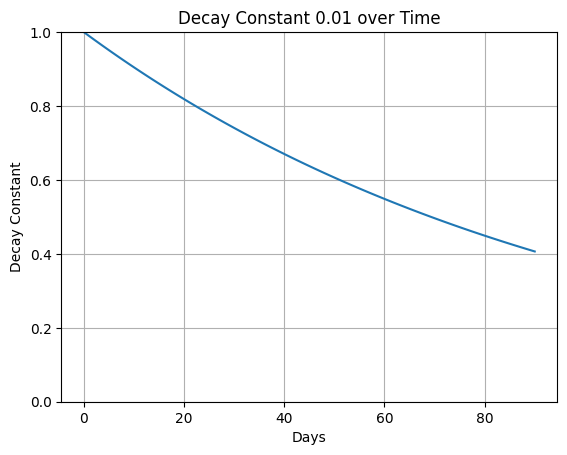

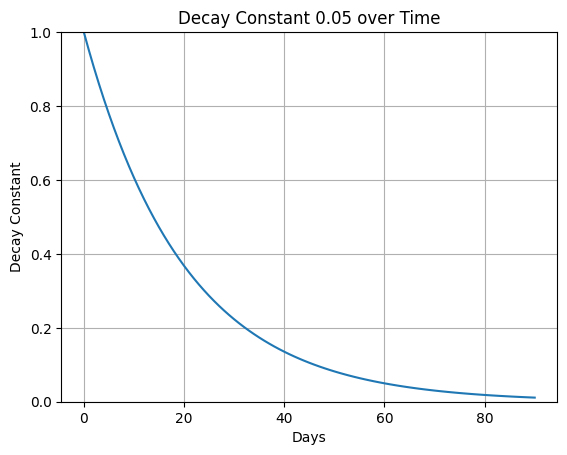

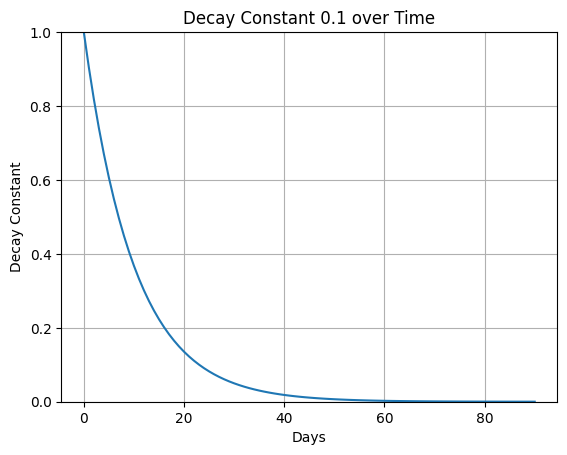

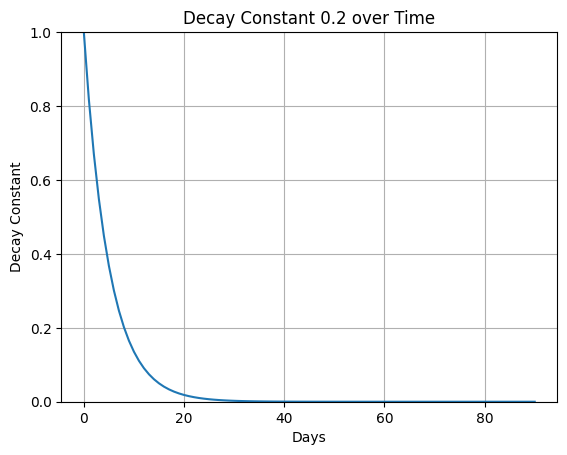

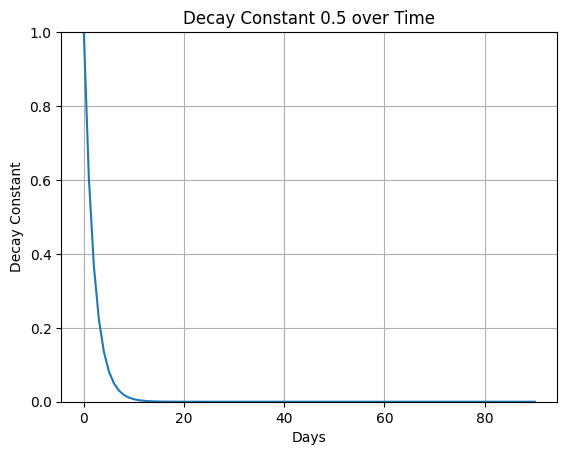

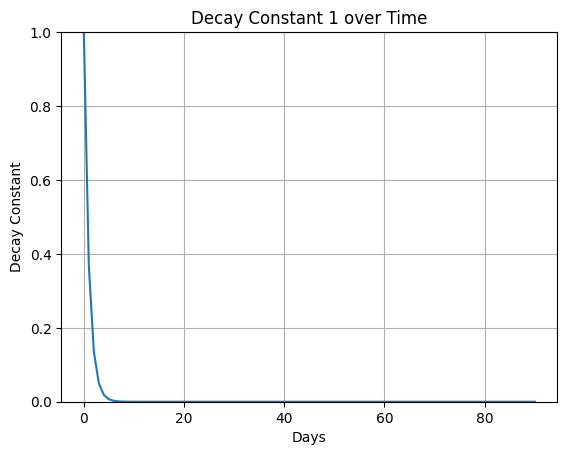

In [ ]:
decay_constants = [0.01, 0.05, 0.1, 0.2, 0.5, 1]

for decay in decay_constants:
    plot_decay_constant_over_time(decay, 90) # 3 months

In [ ]:
content_rec = ContentRecommenderSys(df_t, df_i) # fit transactions and items dataframe into content model

## Making Recommendations

### Importing Validation Set

In [ ]:
df_t_val = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_t_val_fe.pkl')

In [ ]:
df_t_val.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
11983871,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,723529001,0.025407,2,NaT
11983872,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,689898002,0.025407,2,0 days
11983873,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,351484002,0.022017,2,0 days
11983874,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,599580024,0.016932,2,0 days
11852520,2019-06-15,00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...,731160005,0.084729,1,NaT


Lets filter out customers found in the validation set and not found in the training set. We cannot generate recommendations for these customers since they do not exist in the training data.

In [ ]:
customers_in_training = df_t['customer_id'].unique()
df_t_val_filtered = df_t_val[df_t_val['customer_id'].isin(customers_in_training)]

In [ ]:
df_t_val_filtered['customer_id'].unique().shape

(70356,)

In [ ]:
test_customer = df_t_val_filtered['customer_id'].iloc[0]
test_customer

'0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa'

In [ ]:
# Test Customer's Transaction History in Training Set (used to generated recommendations)
test_customer_train = df_t[df_t['customer_id'] == test_customer]['article_id']

# Query item description
df_i[df_i['article_id'].isin(test_customer_train)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding,popularity,price_range
1469,351484002,Lazer Razer Brief,59,Swimwear bottom,Swimwear,Solid,Black,Dark,Black,Ladieswear,Swimwear,"Fully lined bikini bottoms with a mid waist, m...","Lazer Razer Brief, Swimwear bottom, Swimwear, ...","[0.37789053, 1.0946492, -0.34277874, -1.949459...",3988.0,Medium
4179,478646001,Basic Gigi necklace,77,Necklace,Accessories,Solid,Gold,Bright,Metal,Ladieswear,Accessories,"Short, three-strand necklace made up of differ...","Basic Gigi necklace, Necklace, Accessories, Br...","[0.40847722, 0.101798855, 0.6835432, -0.788027...",270.0,Low
25798,614854003,Fiona brazilian (Acacia) 4p,286,Underwear bottom,Underwear,Stripe,Light Pink,Dusty Light,Pink,Ladieswear,"Under-, Nightwear",Brazilian briefs in soft jersey with lace trim...,"Fiona brazilian (Acacia) 4p, Underwear bottom,...","[0.23998247, 0.6225793, -0.04968821, -0.248519...",590.0,Medium
31386,631902006,Majken loafer,144,Flat shoe,Shoes,Solid,Black,Dark,Black,Ladieswear,Shoes,"Loafers with pointed toes. Fabric linings, imi...","Majken loafer, Flat shoe, Shoes, Dark, Black","[0.3585861, 1.9046268, 1.0717446, 0.14653313, ...",104.0,High
33866,640021005,Perrie Trash HW Denim TRS,272,Trousers,Garment Lower body,Solid,Blue,Medium Dusty,Blue,Divided,Trousers,"5-pocket, ankle-length jeans in washed denim w...","Perrie Trash HW Denim TRS, Trousers, Garment L...","[-1.29923, 1.3236579, 1.7441891, 0.77654696, -...",2127.0,High
33868,640021012,Perrie Trash HW Denim TRS,272,Trousers,Garment Lower body,Solid,Black,Dark,Black,Divided,Trousers,"5-pocket, ankle-length jeans in washed denim w...","Perrie Trash HW Denim TRS, Trousers, Garment L...","[-0.9580446, 1.1678075, 1.9689437, 0.7802632, ...",868.0,High
33960,640174001,Lola Lace-Up,252,Sweater,Garment Upper body,Solid,Light Beige,Dusty Light,Beige,Divided,Knitwear,Jumper in a soft rib knit with a deep V-neck w...,"Lola Lace-Up, Sweater, Garment Upper body, Dus...","[-0.22784492, 1.7704914, 1.6207707, 0.5366698,...",13.0,High
38613,658298001,Skirt Mini,275,Skirt,Garment Lower body,Denim,Black,Dark,Black,Ladieswear,Skirts,5-pocket skirt in washed denim with a high wai...,"Skirt Mini, Skirt, Garment Lower body, Dark, B...","[-0.5925999, 1.6747563, 2.2985113, 0.7344411, ...",399.0,High
43106,675319009,Bristol jersey blz,264,Blazer,Garment Upper body,Check,Yellowish Brown,Medium Dusty,Brown,Ladieswear,Dressed,Straight-cut jacket in sturdy jersey with notc...,"Bristol jersey blz, Blazer, Garment Upper body...","[-0.7350195, 1.38203, 1.358305, -0.010932961, ...",408.0,High
52089,700515001,Rosemary Coat,262,Jacket,Garment Upper body,Solid,Dark Beige,Dark,Beige,Ladieswear,Outdoor,Oversized jacket in woven fabric with narrow n...,"Rosemary Coat, Jacket, Garment Upper body, Dar...","[-0.9237826, 1.9394447, 1.449594, 0.14734018, ...",240.0,High


In [ ]:
# Test Customer's Actual Transactions in Validation Set
test_customer_val = df_t_val[df_t_val['customer_id'] == test_customer]['article_id']

# Query item description
df_i[df_i['article_id'].isin(test_customer_val)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding,popularity,price_range
1469,351484002,Lazer Razer Brief,59,Swimwear bottom,Swimwear,Solid,Black,Dark,Black,Ladieswear,Swimwear,"Fully lined bikini bottoms with a mid waist, m...","Lazer Razer Brief, Swimwear bottom, Swimwear, ...","[0.37789053, 1.0946492, -0.34277874, -1.949459...",3988.0,Medium
22643,599580024,Timeless Midrise Brief,59,Swimwear bottom,Swimwear,Stripe,Dark Blue,Dark,Blue,Ladieswear,Swimwear,Fully lined bikini bottoms with a mid waist an...,"Timeless Midrise Brief, Swimwear bottom, Swimw...","[0.09138925, 1.3109787, -0.10725127, -1.784746...",1163.0,Medium
47747,689898002,Timeless Padded Bra,298,Bikini top,Swimwear,Stripe,Dark Blue,Dark,Blue,Ladieswear,Swimwear,"Bikini top with underwired, moulded, lightly p...","Timeless Padded Bra, Bikini top, Swimwear, Dar...","[0.23412636, 1.4543893, -0.72821975, -1.354517...",741.0,Medium
59458,723529001,Lazer Razer Adj. push triangle,298,Bikini top,Swimwear,Solid,Black,Dark,Black,Ladieswear,Swimwear,Triangle bikini top with scalloped trims and g...,"Lazer Razer Adj. push triangle, Bikini top, Sw...","[0.3536323, 0.99531424, -0.21557698, -1.206779...",2146.0,Medium


In [ ]:
test_customer_val

11983871    723529001
11983872    689898002
11983873    351484002
11983874    599580024
Name: article_id, dtype: int64

### Collaborative Filtering

In order to generate the recommendations, we need to first find out which cluster the customer is in.

In [ ]:
df_c_customer_index = df_c.set_index('customer_id') # for faster querying using .loc

In [ ]:
cluster_test_customer = df_c_customer_index.loc[test_customer, 'cluster_key'] # get cluster key
cluster_test_customer

'0_3'

In [ ]:
cluster_closest_neighbours = cluster_to_closest_neighbours_mapping[cluster_test_customer]
cluster_customer_encoder = cluster_to_customer_encoder_mapping[cluster_test_customer]
test_top50_cf = get_top_k_recommendations_for_user(test_customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, 50)
test_top50_cf # Article Ids of Recommendations

9601309     708466003
9537188     729808001
9485847     677999001
11199063    700966003
11018182    697992005
11199060    729808002
11199070    756776002
11018196    594264003
11199071    682550001
11199077    747946002
11199073    742942001
11199074    747946003
11199078    369796032
11199072    746562002
11018192    554640001
8421591     717727002
8421592     707742004
8421593     720506007
8421595     708868003
8421597     713715007
8809433     725178001
8809434     698774001
11018177    693242001
11018178    739144004
8421594     708157007
11018184    732842002
11018186    580770001
11018187    720473002
11018191    739144003
11018190    697992002
11795797    781613002
11795795    764280002
11370836    561445018
11795793    758084002
11370865    707738003
11370864    678942001
11795794    589748001
11795802    781613001
11370859    707743007
11370839    744893006
11370838    771673002
11370837    671852003
11370863    778386002
11795799    723151010
11370862    779987001
11370847  

In [ ]:
# Top 50 Recommendations articles by Collaborative Filtering
df_i[df_i['article_id'].isin(test_top50_cf)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding,popularity,price_range
1685,369796032,John sunglasses,81,Sunglasses,Accessories,Solid,Bronze/Copper,Medium Dusty,Metal,Ladieswear,Accessories,Sunglasses with metal frames and UV-protective...,"John sunglasses, Sunglasses, Accessories, Medi...","[-0.6621429, 0.9773119, 0.79737633, -0.2553043...",227.0,Low
12591,554450011,Julia Denim TRS,272,Trousers,Garment Lower body,Solid,Dark Blue,Medium,Blue,Divided,Trousers,5-pocket jeans in superstretch washed denim wi...,"Julia Denim TRS, Trousers, Garment Lower body,...","[-0.98045284, 1.5047448, 1.9727306, 0.6838751,...",259.0,Medium
12761,554640001,Skirt Torn,275,Skirt,Garment Lower body,Denim,Blue,Medium Dusty,Blue,Divided,Trousers Denim,5-pocket skirt in washed denim with hard-worn ...,"Skirt Torn, Skirt, Garment Lower body, Medium ...","[-1.0856577, 1.8237048, 1.961479, 0.73163325, ...",245.0,High
14082,561445018,Billie.,255,T-shirt,Garment Upper body,Stripe,Dark Blue,Dark,Blue,Ladieswear,Jersey Basic,"Short-sleeved, fitted jersey top with a slight...","Billie., T-shirt, Garment Upper body, Dark, Da...","[-0.15940264, 1.9331827, 1.7504151, -0.2879980...",302.0,Low
18828,580770001,Kai jumper,252,Sweater,Garment Upper body,Solid,Black,Dark,Black,Ladieswear,Knitwear,"Jumper in a soft, rib-knit cotton blend with a...","Kai jumper, Sweater, Garment Upper body, Dark,...","[0.11046262, 1.6689415, 1.8039901, -0.08450103...",398.0,Medium
20629,589748001,Bella waistbelt,67,Belt,Accessories,Solid,Black,Dark,Black,Ladieswear,Accessories,Wide waist belt with a round metal buckle. Wid...,"Bella waistbelt, Belt, Accessories, Dark, Black","[-0.02510345, 1.2304168, 1.5770117, -0.3451764...",429.0,Low
21454,594264003,Ibiza HW Woven Relaxed TRS,272,Trousers,Garment Lower body,Solid,Black,Dark,Black,Divided,Trousers,Trousers in an airy weave with an elasticated ...,"Ibiza HW Woven Relaxed TRS, Trousers, Garment...","[-0.7912201, 1.1460369, 1.9343461, 0.67945457,...",1112.0,Medium
37033,652361001,Prima strap,253,Vest top,Garment Upper body,Solid,Black,Dark,Black,Ladieswear,Blouses,Sleeveless satin top with a V-neck and narrow ...,"Prima strap, Vest top, Garment Upper body, Dar...","[-0.12446514, 1.4256161, 1.0900923, -0.4751232...",23.0,Medium
37034,652361002,Prima strap,253,Vest top,Garment Upper body,Solid,Dark Blue,Medium Dusty,Blue,Ladieswear,Blouses,Sleeveless satin top with a V-neck and narrow ...,"Prima strap, Vest top, Garment Upper body, Med...","[-0.59104234, 1.6949718, 1.0637921, -0.3606135...",35.0,Medium
42225,671852003,Gwen Jersey Top,253,Vest top,Garment Upper body,Solid,Black,Dark,Black,Ladieswear,Dresses Ladies,Fitted top in stretch jersey with a slight she...,"Gwen Jersey Top, Vest top, Garment Upper body,...","[0.015287435, 1.27476, 0.98554724, -0.49249634...",692.0,Medium


### Content-Based Recommender

In [ ]:
test_top50_content = content_rec.get_recommendations(50, test_customer)

In [ ]:
df_i[df_i['article_id'].isin(test_top50_content)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding,popularity,price_range
1515,355072004,Anita Tank (1),253,Vest top,Garment Upper body,Melange,Dark Pink,Dark,Pink,Divided,Jersey Basic,Fitted vest top in soft jersey.,"Anita Tank (1), Vest top, Garment Upper body, ...","[-0.4632398, 1.5042961, 1.1154969, -0.35652077...",23.0,Low
1529,355569005,Nicky Long,253,Vest top,Garment Upper body,Melange,Dark Pink,Dark,Pink,Divided,Jersey Basic,"Long, fitted jersey top with narrow adjustable...","Nicky Long, Vest top, Garment Upper body, Dark...","[-0.36383328, 1.5121113, 1.1198034, -0.4083637...",36.0,Low
2951,443262013,Frank Tank,253,Vest top,Garment Upper body,Treatment,Other Red,Bright,Red,Menswear,Jersey Basic,Vest top in cotton jersey with a chest pocket.,"Frank Tank, Vest top, Garment Upper body, Brig...","[-0.074601404, 1.414449, 0.76715165, -0.746258...",10.0,Low
4737,486329006,Jess,253,Vest top,Garment Upper body,All over pattern,Other Red,Bright,Red,Ladieswear,Blouses,V-neck top in a double layer of crêpe with nar...,"Jess, Vest top, Garment Upper body, Bright, Ot...","[-0.08521628, 1.5518246, 0.8493877, -0.755679,...",1.0,Medium
7500,514817009,LIME STRAP,253,Vest top,Garment Upper body,All over pattern,Dark Pink,Bright,Pink,Divided,Blouses,"Sleeveless top in a viscose weave with narrow,...","LIME STRAP, Vest top, Garment Upper body, Brig...","[-0.31006187, 1.3827398, 1.0176271, -0.4512830...",164.0,Low
8627,524529032,Olga Tank TVP,253,Vest top,Garment Upper body,Solid,Other Orange,Bright,Orange,Divided,Knitwear,Short top in a soft rib knit in a narrow cut a...,"Olga Tank TVP, Vest top, Garment Upper body, B...","[-0.27726766, 1.1794711, 0.7904349, -0.5263628...",NaN,NaN
14655,564045001,LYNN TANK,253,Vest top,Garment Upper body,Melange,Other Pink,Bright,Pink,Sport,Unknown,Sports vest top in fast-drying functional fabr...,"LYNN TANK, Vest top, Garment Upper body, Brigh...","[-0.25109434, 1.3500531, 0.7823893, -0.5398232...",2.0,Low
14656,564045007,LYNN TANK,253,Vest top,Garment Upper body,Melange,Other Pink,Bright,Pink,Sport,Unknown,Sports vest top in fast-drying functional fabr...,"LYNN TANK, Vest top, Garment Upper body, Brigh...","[-0.25109434, 1.3500531, 0.7823893, -0.5398232...",5.0,Low
16703,570843001,BAHAMA MAMA long racerback,253,Vest top,Garment Upper body,Solid,Dark Pink,Bright,Pink,Ladieswear,Jersey Fancy,Sports vest top in fast-drying functional fabr...,"BAHAMA MAMA long racerback, Vest top, Garment ...","[-0.18042131, 1.1605955, 0.82844704, -0.401970...",4.0,Medium
19626,584752004,MAMA LEO,253,Vest top,Garment Upper body,Melange,Dark Purple,Dark,Lilac Purple,Ladieswear,Jersey Fancy,"Fitted top in fast-drying, functional fabric w...","MAMA LEO, Vest top, Garment Upper body, Dark, ...","[-0.22459063, 1.3905029, 1.0045073, -0.5208836...",1.0,Medium


# Evaluation Metrics

In [ ]:
# Recommendations
def eval_relevance(recommendations, test):
    recommendation_embeddings = df_i[df_i['article_id'].isin(recommendations.tolist())]['embedding'].tolist()
    test_embeddings = df_i[df_i['article_id'].isin(test.tolist())]['embedding'].tolist()
    if len(test_embeddings) == 1:
        test_embeddings = np.array(test_embeddings).reshape(1, -1)

    if len(recommendations) == 0:
        return 0.73 # average for random recommendations

    similarities = cosine_similarity(recommendation_embeddings, test_embeddings)
    avg_cosine_similarity = np.mean(similarities)
    return avg_cosine_similarity

def eval_diversity(recommendations):
    # intra-list diversity by evaluating the average Cosine Distance between pairs of items inside the list.
    num_items = len(recommendations)
    if num_items < 2:
        return 0
    embeddings = df_i[df_i['article_id'].isin(recommendations)]['embedding'].tolist()
    cosine_similarities = cosine_similarity(embeddings)

    avg_cosine_similarity = np.mean(cosine_similarities)
    return 1 - avg_cosine_similarity # diversity is the opposite of similarity (more diverse = less similar)

def eval_serendipity(recommendations, training):
    # Dissimilarity between recommendations and historical preferences (training)
    recommendation_embeddings = df_i[df_i['article_id'].isin(recommendations.tolist())]['embedding'].tolist()
    training_embeddings = df_i[df_i['article_id'].isin(training.tolist())]['embedding'].tolist()

    if len(training_embeddings) == 1:
        training_embeddings = np.array(training_embeddings).reshape(1, -1)

    if len(recommendations) == 0:
        return 0.27 #average to random

    similarities = cosine_similarity(recommendation_embeddings, training_embeddings)
    avg_dissimilarity = 1 - np.mean(similarities)
    return avg_dissimilarity


In [ ]:
print('Relevance Score of Content Based Filtering:', eval_relevance(test_top50_content, test_customer_val))
print('Relevance Score of Collaborative Filtering:', eval_relevance(test_top50_cf, test_customer_val))

Relevance Score of Content Based Filtering: 0.68535584
Relevance Score of Collaborative Filtering: 0.56435853


In [ ]:
print('Diversity of Content Based Filtering:', eval_diversity(test_top50_content))
print('Diversity of Collaborative Filtering:', eval_diversity(test_top50_cf))

Diversity of Content Based Filtering: 0.0170629620552063
Diversity of Collaborative Filtering: 0.21038490533828735


In [ ]:
print('Serendipity of Content Based Filtering:', eval_serendipity(test_top50_content, test_customer_train))
print('Serendipity of Collaborative Filtering:', eval_serendipity(test_top50_cf, test_customer_train))

Serendipity of Content Based Filtering: 0.26241111755371094
Serendipity of Collaborative Filtering: 0.29445260763168335


# Preparing Validation Set for Hyperparameter Search

In [ ]:
customers_in_training = df_t['customer_id'].unique()
df_t_val_filtered = df_t_val[df_t_val['customer_id'].isin(customers_in_training)]

In [ ]:
df_t_val_filtered['customer_id'].unique().shape # only customers that were found in training set previously

(70356,)

In [ ]:
customer_ids = df_c['customer_id'].unique()
filtered_df_t_val = df_t_val_filtered[df_t_val_filtered['customer_id'].isin(customer_ids)]
df_t_val_index_customer = filtered_df_t_val.set_index('customer_id')

df_t_train_index_customer = df_t.set_index('customer_id')

# Hyperparameter Selection of Decay Constant for Content-Based Recommmender

In [ ]:
import random

# Hyperparameter selection for decay constant
decay_constants = [0.01, 0.05, 0.1, 0.2]

customers_to_recommend = random.sample(df_t_val_index_customer.index.unique().tolist(), 200)

for decay in decay_constants:
    total_relevance_content = 0
    for customer in customers_to_recommend:
        top20_content = content_rec.get_recommendations(20, customer, decay)
        customer_purchases = df_t_val[df_t_val['customer_id'] == customer]['article_id']
        total_relevance_content += eval_relevance(top20_content, customer_purchases)

    avg_relevance_score = total_relevance_content / 200
    print(f"Decay constant ({decay}) relevance score: {avg_relevance_score}")

Decay constant (0.01) relevance score: 0.7924970342218876
Decay constant (0.05) relevance score: 0.7844945995509625
Decay constant (0.1) relevance score: 0.7786619731783867
Decay constant (0.2) relevance score: 0.7702358186244964


Decay constant 0.01 results in the highest relevance score. This means that there is merit in attaching weights to past historical preferences as it resulted in better content-based recommendations.

# Comparison between Content-Based Filtering and Collaborative Filtering

In [ ]:
import random


# Initialise Evaluation Metrics
relevance = {'cf' : [], 'content' : [], 'random' : []}
diversity = {'cf' : [], 'content' : [], 'random' : []}
serendipity = {'cf' : [], 'content' : [], 'random' : []}

K = 20 # Number of Recommendations
N_SAMPLES = 300

customers_to_recommend = random.sample(df_t_val_index_customer.index.unique().tolist(), N_SAMPLES)

for customer in customers_to_recommend:
    # Querying
    customer_train = pd.Series(df_t_train_index_customer.loc[customer, 'article_id']) # historical transactions
    customer_test = pd.Series(df_t_val_index_customer.loc[customer, 'article_id']) # what was actually bought

    # Collaborative Filtering
    cluster_customer = df_c_customer_index.loc[customer, 'cluster_key'] # get cluster key
    cluster_closest_neighbours = cluster_to_closest_neighbours_mapping[cluster_customer] # get closest neighbours using cluster key
    cluster_customer_encoder = cluster_to_customer_encoder_mapping[cluster_customer] # get customer encoder using cluster key
    cf_recommendations = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, K) # generate cf recommendations

    relevance['cf'].append(eval_relevance(cf_recommendations, customer_test))
    diversity['cf'].append(eval_diversity(cf_recommendations))
    serendipity['cf'].append(eval_serendipity(cf_recommendations, customer_train))

    # Content Based Filtering
    content_recommendations = content_rec.get_recommendations(K, customer, 0.01) # decay_constant = 0.01

    relevance['content'].append(eval_relevance(content_recommendations, customer_test))
    diversity['content'].append(eval_diversity(content_recommendations))
    serendipity['content'].append(eval_serendipity(content_recommendations, customer_train))

    # Random
    random_recommendations = pd.Series(random.sample(df_i['article_id'].unique().tolist(), K))

    relevance['random'].append(eval_relevance(random_recommendations, customer_test))
    diversity['random'].append(eval_diversity(random_recommendations))
    serendipity['random'].append(eval_serendipity(random_recommendations, customer_train))

In [ ]:
avg_metrics = {}
for model, metrics in relevance.items():
    avg_relevance = np.mean(metrics)
    avg_diversity = np.mean(diversity[model])
    avg_serendipity = np.mean(serendipity[model])
    avg_metrics[model] = {'relevance': avg_relevance, 'diversity': avg_diversity, 'serendipity': avg_serendipity}

for model, metrics in avg_metrics.items():
    print(f"Model: {model}")
    print(f"Average Relevance: {metrics['relevance']}")
    print(f"Average Diversity: {metrics['diversity']}")
    print(f"Average Serendipity: {metrics['serendipity']}")
    print()

Model: cf
Average Relevance: 0.7285076277534167
Average Diversity: 0.2328509130080541
Average Serendipity: 0.2479235798041026

Model: content
Average Relevance: 0.7882169485092163
Average Diversity: 0.0176325782140096
Average Serendipity: 0.11402251680692037

Model: random
Average Relevance: 0.7220821380615234
Average Diversity: 0.24897432188193003
Average Serendipity: 0.2703544893860817



# Weight Hyperparameter Tuning for Hybrid Recommendations Model

Cluster 1 (Diversity Prone): 50% of recommendations come from Content Based Filtering, 50% of recommendations come from Collaborative Filtering.

Cluster 2 (Relevance to Historical items prone): X% of recommendations come from Content Based Filtering, Y% of recommendations come from Collaborative Filtering.

In [ ]:
import random

thresholds = [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]] # thresholds
thresholds = {index: value for index, value in enumerate(thresholds)}

# Initialise Evaluation Metrics
relevance = {} # threshold : list of score mapping
diversity = {} # threshold : list of score mapping
serendipity = {} # threshold : list of score mapping

K = 50
N_SAMPLES = 200

customers_to_recommend = random.sample(df_t_val_index_customer.index.unique().tolist(), N_SAMPLES)

for customer in customers_to_recommend:
    # Querying
    customer_train = pd.Series(df_t_train_index_customer.loc[customer, 'article_id']) # historical transactions
    customer_test = pd.Series(df_t_val_index_customer.loc[customer, 'article_id']) # what was actually bought

    # Collaborative Filtering
    cluster_customer = df_c_customer_index.loc[customer, 'cluster_key'] # get cluster key
    cluster_closest_neighbours = cluster_to_closest_neighbours_mapping[cluster_customer] # get closest neighbours using cluster key
    cluster_customer_encoder = cluster_to_customer_encoder_mapping[cluster_customer] # get customer encoder using cluster key
    cf_recommendations = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, K) # generate cf recommendations

    # Content Based Filtering
    content_recommendations = content_rec.get_recommendations(K, customer, 0.01) # decay_constant = 0.01

    for index, threshold in thresholds.items():
        n_content = int(threshold[0] * K) # number of items to recommend for content model
        n_cf = int(threshold[1] * K) # number of items to recommend for cf model

        cf_subset = cf_recommendations[:n_cf]
        content_subset = content_recommendations[:n_content]
        final_recommendations = pd.concat([cf_subset, content_subset])

        if index not in relevance.keys():
            relevance[index] = []
        if index not in diversity.keys():
            diversity[index] = []
        if index not in serendipity.keys():
            serendipity[index] = []

        relevance[index].append(eval_relevance(final_recommendations, customer_test))
        diversity[index].append(eval_diversity(final_recommendations))
        serendipity[index].append(eval_serendipity(final_recommendations, customer_train))

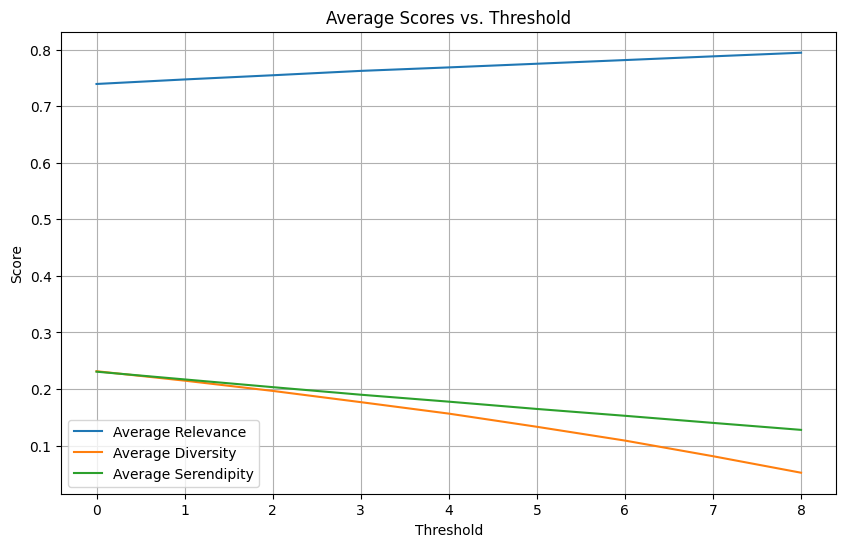

In [ ]:
avg_relevance = {threshold: np.mean(scores) for threshold, scores in relevance.items()}
avg_diversity = {threshold: np.mean(scores) for threshold, scores in diversity.items()}
avg_serendipity = {threshold: np.mean(scores) for threshold, scores in serendipity.items()}

# Create lists of threshold values and average scores for each metric
thresholds_list = list(avg_relevance.keys())
avg_relevance_list = list(avg_relevance.values())
avg_diversity_list = list(avg_diversity.values())
avg_serendipity_list = list(avg_serendipity.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds_list, avg_relevance_list, label='Average Relevance')
plt.plot(thresholds_list, avg_diversity_list, label='Average Diversity')
plt.plot(thresholds_list, avg_serendipity_list, label='Average Serendipity')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Average Scores vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Econometrics Analysis on Models

Hypothesis: There is a significant relationship between the number of transactions in a user's history (train) and the relevance of recommendations they receive.

In [ ]:
# Initialise Evaluation Metrics
relevance = {'cf' : [], 'content' : [], 'random' : []}
diversity = {'cf' : [], 'content' : [], 'random' : []}
serendipity = {'cf' : [], 'content' : [], 'random' : []}
number_transactions = [] # user to number of historical transactions mapping

K = 20 # Number of Recommendations
N_SAMPLES = 500

customers_to_recommend = random.sample(df_t_val_index_customer.index.unique().tolist(), N_SAMPLES)

for customer in customers_to_recommend:
    # Querying
    customer_train = pd.Series(df_t_train_index_customer.loc[customer, 'article_id']) # historical transactions
    customer_test = pd.Series(df_t_val_index_customer.loc[customer, 'article_id']) # what was actually bought
    number_transactions.append(len(customer_train))

    # Collaborative Filtering
    cluster_customer = df_c_customer_index.loc[customer, 'cluster_key'] # get cluster key
    cluster_closest_neighbours = cluster_to_closest_neighbours_mapping[cluster_customer] # get closest neighbours using cluster key
    cluster_customer_encoder = cluster_to_customer_encoder_mapping[cluster_customer] # get customer encoder using cluster key
    cf_recommendations = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, K) # generate cf recommendations

    relevance['cf'].append(eval_relevance(cf_recommendations, customer_test))
    diversity['cf'].append(eval_diversity(cf_recommendations))
    serendipity['cf'].append(eval_serendipity(cf_recommendations, customer_train))

    # Content Based Filtering
    content_recommendations = content_rec.get_recommendations(K, customer, 0.01) # decay_constant = 0.01

    relevance['content'].append(eval_relevance(content_recommendations, customer_test))
    diversity['content'].append(eval_diversity(content_recommendations))
    serendipity['content'].append(eval_serendipity(content_recommendations, customer_train))

    # Random
    random_recommendations = pd.Series(random.sample(df_i['article_id'].unique().tolist(), K))

    relevance['random'].append(eval_relevance(random_recommendations, customer_test))
    diversity['random'].append(eval_diversity(random_recommendations))
    serendipity['random'].append(eval_serendipity(random_recommendations, customer_train))

### Regression Test on Collaborative Filtering Relevance Results

In [ ]:
import statsmodels.api as sm

data = pd.DataFrame({
    'num_transactions': number_transactions,
    'cf_relevance': relevance['cf'],
    'content_relevance': relevance['content'],
    'random_relevance': relevance['random']
})

X = data['num_transactions']
y = data['cf_relevance']

X = sm.add_constant(X) # add intercept

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           cf_relevance   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.629
Date:                Sat, 13 Apr 2024   Prob (F-statistic):             0.0180
Time:                        12:34:34   Log-Likelihood:                 482.98
No. Observations:                 500   AIC:                            -962.0
Df Residuals:                     498   BIC:                            -953.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7153      0.006  

### Regression Test on Content Based Filtering Relevance Results

In [ ]:
X = data['num_transactions']
y = data['content_relevance']

X = sm.add_constant(X) # add intercept

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      content_relevance   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     14.46
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           0.000161
Time:                        12:35:27   Log-Likelihood:                 313.56
No. Observations:                 500   AIC:                            -623.1
Df Residuals:                     498   BIC:                            -614.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7690      0.008  

### Regression Test on Random Filtering Relevance Results

In [ ]:
X = data['num_transactions']
y = data['random_relevance']

X = sm.add_constant(X) # add intercept

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       random_relevance   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.675
Date:                Sat, 13 Apr 2024   Prob (F-statistic):             0.0558
Time:                        12:35:31   Log-Likelihood:                 502.67
No. Observations:                 500   AIC:                            -1001.
Df Residuals:                     498   BIC:                            -992.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7178      0.006  

### Conclusions

p-value of coefficient estimate in Collaborative Filtering: 0.018

p-value of coefficient estimate in Content-Based Filtering: 0.000

p-value of coefficient estimate in Random Filtering: 0.056


At the 5% level of significance, the p-values for the coefficient estimates of both collaborative filtering and content-based filtering models are less than 0.05, indicating statistical significance. This suggests that the number of transactions (num_transactions) has a significant effect on the relevance score when using these filtering methods.

However, for the random filtering model, the p-value for the coefficient estimate of num_transactions is greater than 0.05, implying a lack of statistical significance on the coefficient estimate. Therefore, there is insufficient evidence to conclude that the number of transactions significantly influences the relevance score in the case of random filtering.

The main insight from this experiment is that customers that have made larger number of purchases would receive more relevant recommendations from both our collaborative and content-based filtering models. This is because both models utilises information from the historical transactions to find other similar customers for collaborative recommendations (collaborative filtering) and applying weights to historical transactions to make personalised recommendations for the customer (content-based filtering).

# Evaluating on Test Set

In [ ]:
df_t_test = pd.read_pickle("/content/drive/MyDrive/BT4222/data/pickles/df_t_test_fe.pkl")
df_t_test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
14479578,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,0.012695,1,NaT
14479579,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001,0.021169,1,0 days
13329240,2019-07-05,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,559616014,0.025407,2,NaT
13329241,2019-07-05,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,757974002,0.025407,2,0 days
13329242,2019-07-05,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,615047003,0.008458,2,0 days


In [ ]:
df_t_test['t_dat'].min()

Timestamp('2019-07-01 00:00:00')

In [ ]:
df_t_test['t_dat'].max()

Timestamp('2019-07-31 00:00:00')

In [ ]:
len(df_t_test)

1807494

Due to large size of the test dataset, we decided to further narrow down our test dataset to a period of 1 week.

In [ ]:
df_t_test_filtered = df_t_test[df_t_test['t_dat'] < '2019-07-08']
customer_ids = df_c['customer_id'].unique()
df_t_test_filtered = df_t_test_filtered[df_t_test_filtered['customer_id'].isin(customer_ids)] # filter away customers that did not previously exist in the train set

Previously, we withheld the validation set from training. Now, we will include the validation dataset into the training process.

In [ ]:
df_combined_t = pd.concat([df_t, df_t_val])
week_of_purchase = df_combined_t['t_dat'].dt.isocalendar().week.astype('int')
min_week = week_of_purchase.min()
week_of_purchase_zeroed = week_of_purchase - min_week
df_combined_t['week_of_purchase'] = week_of_purchase_zeroed # set transaction week

In [ ]:
len(df_t_test_filtered['customer_id'].unique())

66926

In [ ]:
df_t_test_filtered = df_t_test_filtered[df_t_test_filtered['customer_id'].isin(df_combined_t['customer_id'].unique())]

In [ ]:
df_t_test_filtered_customer_index = df_t_test_filtered.set_index('customer_id') # set index as customer id
df_combined_t_customer = df_combined_t.set_index('customer_id') # set index as customer id

In [ ]:
cluster_to_closest_neighbours_mapping_test = {}
cluster_to_customer_encoder_mapping_test = {}
cluster_to_article_encoder_mapping_test = {}

for cluster_key in df_c['cluster_key'].unique():
    user_similarity, customer_encoder, article_encoder = compute_user_similarity(df_combined_t, df_c, cluster_key) # remodel on combined df (train + val)

    # Within the user_similarity matrix, retrieve the top 50 closest neighbours
    cluster_to_closest_neighbours_mapping_test[cluster_key] = top_k_neighbors(user_similarity, k=50)
    cluster_to_customer_encoder_mapping_test[cluster_key] = customer_encoder
    cluster_to_article_encoder_mapping_test[cluster_key] = article_encoder

In [ ]:
content_rec_test = ContentRecommenderSys(df_combined_t, df_i) # remodel on combined dataframe (train + val)

In [ ]:
import random

# Initialise Evaluation Metrics
total_relevance_content_test = 0
total_diversity_content_test = 0
total_serendipity_content_test = 0

total_relevance_cf_test = 0
total_diversity_cf_test = 0
total_serendipity_cf_test = 0

total_relevance_combined_test = 0
total_diversity_combined_test = 0
total_serendipity_combined_test = 0

total_relevance_random_test = 0
total_diversity_random_test = 0
total_serendipity_random_test = 0

for customer in df_t_test_filtered['customer_id'].unique():
    # Querying
    customer_train = pd.Series(df_t_train_index_customer.loc[customer, 'article_id']) # historical transactions
    customer_test = pd.Series(df_t_test_filtered_customer_index.loc[customer, 'article_id']) # what was actually bought

    # Collaborative Filtering
    cluster_customer = df_c_customer_index.loc[customer, 'cluster_key'] # get cluster key
    cluster_closest_neighbours = cluster_to_closest_neighbours_mapping_test[cluster_customer]
    cluster_customer_encoder = cluster_to_customer_encoder_mapping_test[cluster_customer]

    #top20_cf = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, 20)
    top20_cf = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_combined_t, cluster_customer_encoder, 20)

    total_relevance_cf_test += eval_relevance(top20_cf, customer_test)
    total_diversity_cf_test += eval_diversity(top20_cf)
    total_serendipity_cf_test += eval_serendipity(top20_cf, customer_train)

    # Content Based Filtering
    top20_content = content_rec_test.get_recommendations(20, customer, 0.5) # decay_constant = 0.5

    total_relevance_content_test += eval_relevance(top20_content, customer_test)
    total_diversity_content_test += eval_diversity(top20_content)
    total_serendipity_content_test += eval_serendipity(top20_content, customer_train)

    # Equal Proportions from Collaborative Filtering and Content Based Filtering
    top10_cf = top20_cf[:10]
    top10_content = content_rec_test.final_recommendations[customer][:10] # using the previously saved recommendations
    top20_combined = pd.concat([top10_cf, top10_content])

    total_relevance_combined_test += eval_relevance(top20_combined, customer_test)
    total_diversity_combined_test += eval_diversity(top20_combined)
    total_serendipity_combined_test += eval_serendipity(top20_combined, customer_train)

    # Random Recommendations (Baseline)
    random_20 = pd.Series(random.sample(df_i['article_id'].unique().tolist(), 20))
    total_relevance_random_test += eval_relevance(random_20, customer_test)
    total_diversity_random_test += eval_diversity(random_20)
    total_serendipity_random_test += eval_serendipity(random_20, customer_train)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
N_SAMPLES = len(df_t_test_filtered['customer_id'].unique()) # total number of customers

average_relevance_cf_test = total_relevance_cf_test / N_SAMPLES
average_diversity_cf_test = total_diversity_cf_test / N_SAMPLES
average_serendipity_cf_test = total_serendipity_cf_test / N_SAMPLES

average_relevance_content_test = total_relevance_content_test / N_SAMPLES
average_diversity_content_test = total_diversity_content_test / N_SAMPLES
average_serendipity_content_test = total_serendipity_content_test / N_SAMPLES

average_relevance_combined_test = total_relevance_combined_test / N_SAMPLES
average_diversity_combined_test = total_diversity_combined_test/ N_SAMPLES
average_serendipity_combined_test = total_serendipity_combined_test / N_SAMPLES

average_relevance_random_test = total_relevance_random_test / N_SAMPLES
average_diversity_random_test = total_diversity_random_test / N_SAMPLES
average_serendipity_random_test = total_serendipity_random_test / N_SAMPLES

In [ ]:
print('Collaborative Filtering Relevance', average_relevance_cf_test)
print('Collaborative Filtering Diversity', average_diversity_cf_test)
print('Collaborative Filtering Serendipity', average_serendipity_cf_test)
print('\n')

print('Content Filtering Relevance', average_relevance_content_test)
print('Content Filtering Diversity', average_diversity_content_test)
print('Content Filtering Serendipity', average_serendipity_content_test)
print('\n')

print('Content + Collaborative Filtering Relevance', average_relevance_combined_test)
print('Content + Collaborative Filtering Diversity', average_diversity_combined_test)
print('Content + Collaborative Filtering Serendipity', average_serendipity_combined_test)
print('\n')

print('Random Filtering Relevance', average_relevance_random_test)
print('Random Filtering Diversity', average_diversity_random_test)
print('Random Filtering Serendipity', average_serendipity_random_test)